# Wetter API

In [19]:
import requests # Library to access URLs using Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor # Random Forest estimator


## Get Forcast weather data

### Get data

In [20]:
# Build the  Querry for the URL
def build_query_string(base_url, params_dict):
    # Create a string of param1=value1&param2=value2&...
    params_str = "&".join(f"{k}={v}" for k,v in params_dict.items())
    # Concatenate this string with the base URL and return
    return f"{base_url}?{params_str}"

In [21]:
# Set the API key
api_key = "ba6cf0fabcb9f0ec1029c1a0a7949ec4"

In [22]:
# Set the base URL
geo_url = "http://api.openweathermap.org/geo/1.0/direct"

# Set the parameter to get the location
geo_params = {
    "q": "Köln",
    "appid": api_key
}

# Create the API query URL
query = build_query_string(geo_url, geo_params)

# Obtain the data from the API call
geo_data = requests.get(query).json()

In [23]:
# Define the base URL of the forecast API
forcast_url = "https://api.openweathermap.org/data/2.5//forecast"

# Define the parameters of our query to the air pollution API
airpol_params = {
    "lat": geo_data[0]["lat"], # The latitude of our chosen city
    "lon": geo_data[0]["lon"], # The longitude of our chosen city
    "appid": api_key, # Our API key
    "units": "metric"
}

weather = requests.get(build_query_string(forcast_url, airpol_params)).json()

In [24]:
# Extract a list of relevant dictionaries
observations_temp = []
observations_weather = []

for datapoint in weather["list"]:
    # Keep track of all temperature
    obs_t = datapoint["main"]
    # Add the date and time to the dict
    obs_t["date"] = datapoint["dt"]
    # Add the observation to the list of observations
    observations_temp.append(obs_t)

    # Keep track of all weather data
    obs_w = datapoint["weather"][0]
    # Add the date and time to the dict
    obs_w["date"] = datapoint["dt"]
    # Add the observation to the list of observations
    observations_weather.append(obs_w)

# Saving data from API in a Dataframe to merge
df_t = pd.DataFrame.from_records(observations_temp)
df_w = pd.DataFrame.from_records(observations_weather)

### Change to hourly

In [25]:
# Merging data and changing date formate
df = pd.merge(df_t, df_w, how= "right", on = "date")
df["date"] = pd.to_datetime(df["date"], unit="s")

# buildng this as hourly with cloned rows
df_repeated = pd.concat([df]*3, ignore_index=True)
df_repeated.loc[[0,40,80]]

# Create a list to store the order of new indexs
new_index = []
# Changing the Dataframe to every hour
for n in range(int(len(df_repeated)/3)):
    new_index.append(n)
    new_index.append(n+40)
    new_index.append(n+80)

# Reset the index
df_repeated = df_repeated.reindex(new_index)
df_repeated.reset_index(inplace = True, drop = True)

# Getting a step by step change in temperature by usint the three hour steps and distripute the change evenly
for n in range(int(len(df_repeated)/3)-1):
    start_index = n*3
    end_index = (n*3)+3
    start = df_repeated.loc[start_index,"temp"]
    end = df_repeated.loc[end_index,"temp"]
    difference = end - start
    steps = round(difference/3,2)
    df_repeated.loc[start_index+1,"temp"] = df_repeated.loc[start_index,"temp"] + steps
    df_repeated.loc[start_index+2,"temp"] = df_repeated.loc[start_index,"temp"] + steps + steps

# Drop unimportant rows
df_repeated = df_repeated.drop(df_repeated.iloc[:,1:9],axis = 1)

In [26]:
# Setting the Hour intervals for the Dataframe
for n in range(int(len(df_repeated)/3)):
    start_index = n*3
    df_repeated.loc[start_index+1,"date"] = df_repeated.loc[start_index,"date"] + timedelta(hours=1)
    df_repeated.loc[start_index+2,"date"] = df_repeated.loc[start_index,"date"] + timedelta(hours=2)

# Splitting the date and time for a merge
df_repeated["date"] = df_repeated["date"].astype(str)
df_repeated[["date", "time"]] = df_repeated["date"].str.split(" ", n=1, expand=True)
df_repeated

# Get Column with months
df_repeated["months"] = df_repeated["date"].str.slice(5, 7)

# Transform time to hours
df_repeated["hour"] = df_repeated["time"].str.slice(0, 2)

### Future School Holiday

In [27]:
# Import Dataframe from the holidays
future_school_holi = pd.read_csv("future_school_holiday.csv", sep = ";")
days_df_list = []

# Create dataframe with all dates singular listed 
for i in range(future_school_holi.shape[0]):
    # Get the start and enddate from the holidays
    start_date = datetime.strptime(future_school_holi["Erster Ferientag"][i], "%Y-%m-%d").date()
    end_date = datetime.strptime(future_school_holi["Letzter Ferientag"][i], "%Y-%m-%d").date()

    # Create dataframes out of the range and append to a list
    delta = end_date - start_date
    days = [start_date + timedelta(days=n) for n in range(delta.days + 1)]
    days_df = pd.DataFrame (days, columns = ["date"])
    days_df_list.append(days_df)

# Create single dataframe out of the list and add value 1 for holiday
new_holi = pd.concat(days_df_list).reset_index(drop=True)
new_holi["school holiday"] = 1

# Chagne to str for merge
new_holi["date"] = new_holi["date"].astype(str)

In [28]:
# Merging the weather data an the holidays
df_merge1 = pd.merge(df_repeated, new_holi, how= "left", on = "date")
# Filling cells with no holiday with a 0
df_merge1["school holiday"] = df_merge1["school holiday"].fillna(0)
# change float to int
df_merge1["school holiday"] = np.int64(df_merge1["school holiday"].astype(int))

### Future National Holiday

In [29]:
# Getting the current year 
today = dt.date.today()
year = int(today.strftime("%Y"))

# Putting this and the next year into a list to claculate the holidays
this_plus_next_year = [year,year + 1]

future_holidays_list = []

for intput_year in this_plus_next_year:
    # Formular for calculating easter sunday
    k = intput_year // 100
    m = 15 + (3 * k + 3) // 4 - (8 * k + 13) // 25
    s = 2 - (3*k + 3) // 4
    a = intput_year % 19

    d = (19* a + m) % 30
    r = (d + a // 11) // 29
    og = 21 + d - r
    sz = 7 - (intput_year + intput_year // 4 + s) % 7

    oe =  7 - (og - sz) % 7

    # Days for easter sunday after teh first march (because daytime starts at first minus 1 again)
    os = og + oe -1
    first_march = date(intput_year, 3, 1)

    # Calculating the date for easter sunday
    os_date = first_march + timedelta(days=os)


    # The flexible holidays calculated from easter sunday
    karfreitag = os_date - timedelta(days=2)
    os_date = os_date
    easter_monday = os_date + timedelta(days=1)
    ascension = os_date + timedelta(days=39)
    white_monday = os_date + timedelta(days=50)
    corpus_christ = os_date + timedelta(days=60)

    # The fixed holidays (for nrw)
    new_year = date(intput_year, 1, 1)
    day_of_work = date(intput_year, 5, 1)
    germany_united = date(intput_year, 10, 3)
    saints_day = date(intput_year, 11, 1)
    first_christmas = date(intput_year, 12, 25)
    second_christmas =date(intput_year, 11, 26)

    # Creating dataframe with holidays
    holiday_list_future = [new_year, karfreitag, os_date, easter_monday, day_of_work, ascension, white_monday, corpus_christ, germany_united, saints_day, first_christmas, second_christmas]
    future_holidays = pd.DataFrame ({"date": holiday_list_future,
                                    "holiday": [1 for i in range(len(holiday_list_future))]})
    future_holidays_list.append(future_holidays)

# Connect the holidays from this and the nex year
df_future_holidays = pd.concat(future_holidays_list)

In [30]:
# Merging the holidays with the alredy merged dataframe
df_merge2 = pd.merge(df_merge1, df_future_holidays, how= "left", on = "date")
# Fill no holidays with zeros
df_merge2["holiday"] = df_merge2["holiday"].fillna(0)
#change float to int
df_merge2["holiday"] = np.int64(df_merge2["holiday"].astype(int))

### Getting the training data for Pedestriants

In [31]:
#Getting the Dataframe for the prediction without pca
ped = pd.read_csv("data_clean_without_dummies.csv", sep = ";", index_col=0)
#restructure month for later
ped["months"] = ped["months"].astype(str)
ped["months"] = ped["months"].str.zfill(2)

In [32]:
# Putting the holidays in the last two places to mak it easier to assign the parameters for learning

def reindexing(column_name, dataframe):
    return dataframe.reindex(columns = [col for col in dataframe.columns if col != column_name] + [column_name])

ped = reindexing("school holiday", ped)
ped = reindexing("holiday", ped)

### Creating dummies for the weather

In [33]:
#Values from weather and key from pedestriant data
######################################################
# Because the API Used by the pedestriant count is no longer the old provider and not free, we used another API. This does not match all the Notations regarding the weather, so we had to set the Drizzle equal with Wind.
# This is not 100% Accuarte but is also not that comon in the dataset or the API. Furthermore we had to set all other variables in Atmosphere Group (ID7xx) from the weather api besides Mist to nan. Bu since Ash, Tornados, etc. are not that comon in 
# Köln this does not have a big impact.  
#######################################################
dict_weather = {'rain':"Thunderstorm",
                'wind':"Drizzle",
                'rain':"Rain",
                "snow":"Snow",
                "fog":'Mist',
                "clear-night":"Clear",
                "clear-day":"Clear",
                "cloudy":"Clouds",
                "partly-cloudy-night":"Clouds",
                "partly-cloudy-day":"Clouds",
                }


# Create columns with rows for zero, becuase we dont use get_dummies, to be sure it is not mixing the rows up
def create_columns_dict(dataframe, dict_col):
    for col_name in dict_col.values():
        dataframe[col_name] = 0

# Use the function for boath datasets
create_columns_dict(ped, dict_weather)
create_columns_dict(df_merge2, dict_weather)


# Fill the according columns in both Datasets for the weather 
def fill_weather(dataframe, column, dictionary):
    for i in range(len(dataframe)):
        weather = dataframe.loc[i, column]
# For pedestraints or for weather
        value = next((v for k, v in dict_weather.items() if v == weather or k == weather), "nan")
        dataframe.loc[i, value] = 1


# Using the function for the Weather data and the Pedestirants data
fill_weather(ped, "weather condition", dict_weather)
fill_weather(df_merge2, "main", dict_weather)


### Creating dummies for the months

In [34]:
# Create a function to create and fill the Columns of the months
def fill_months(data_frame, Month_list, Column):
    for month in Month_list:
        data_frame[month] = 0
    for i in range(len(data_frame)):
        month = data_frame.loc[i, Column]
        for number_months in range(len(Month_list)):
            number_months_str = str(number_months+1).zfill(2)
            if month == number_months_str:
                data_frame.loc[i, Month_list[number_months]] = 1

In [35]:
# Create a list wiht all months
Months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Using the function for the Weather data and the Pedestirants data
fill_months(df_merge2, Months, "months")
fill_months(ped, Months, "months")


### Creating dummies for the weekdays

In [36]:
# Create a function to create and fill the Columns of the months
def fill_weekdays(data_frame, Weekdays_list, Column):
    for days in Weekdays_list:
        data_frame[days] = 0
    for i in range(len(data_frame)):
        if Column == "weekday":
            day = data_frame.loc[i, "weekday"]
        if Column != "weekday":
            day = datetime.strptime(data_frame.loc[i, "date"], "%Y-%m-%d").strftime('%A')
        for weekday in Weekdays_list:
            if day == weekday:
                data_frame.loc[i, weekday] = 1



In [37]:
#Create list with weekdays
Weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# Using the function for the Weather data and the Pedestirants data
fill_weekdays(df_merge2, Weekdays, "date")
fill_weekdays(ped, Weekdays, "weekday")


### Creating dummies for the hours 

In [38]:
# Create a function to create and fill the Columns of the months
def fill_hours(data_frame, Column):
    # Creating columns with the hours and setting them 0
    hour_in_day =  list(data_frame[Column].unique())
    hour_in_day.sort()
    for time in hour_in_day:
      data_frame[time] = 0
    # Going over the dataframe and changing to 1
    for i in range(len(data_frame)):
        time = data_frame.loc[i, Column]
        for hour in hour_in_day:
            if time == hour:
                data_frame.loc[i, time] = 1

In [39]:
# Using the function for the Weather data and the Pedestirants data
fill_hours(df_merge2, "time")
fill_hours(ped, "time")

### Standardize the temperature

In [40]:
# Use the mean and the std from the Pedestirants data
mean_used = ped["temperature in ºc"].mean()
std_used = ped["temperature in ºc"].std()

# Create a function to standardize
def standardize(df, column, mean, std):
    df["temperature"] = (df[column] - mean) / std

# Using the function for the Weather data and the Pedestirants data
standardize(ped, "temperature in ºc", mean_used, std_used)
standardize(df_merge2, "temp", mean_used, std_used)

# Save the pedestraint data
ped.to_csv("Pedestriant_df_for_forecast.csv", sep=";")

## Forcasting

### Training Data

In [41]:
ped = pd.read_csv("Pedestriant_df_for_forecast.csv", sep=";", index_col=0)
# Define a X
X = ped[ped.columns[8:]]
# Output to predict
y = ped["pedestrians count"]


# Define a X for the forecast
X_forecast = df_merge2[df_merge2.columns[9:]]


# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

In [42]:
examplatory_forecast_model = RandomForestRegressor(random_state=144,n_jobs=-1)
examplatory_forecast_model.fit(Xtrain, ytrain)

RandomForestRegressor(n_jobs=-1, random_state=144)

In [43]:
def get_mae(y_data, x_data, model):
    mae = mean_absolute_error(y_data, model.predict(x_data))
    return mae
    
mae_train = get_mae(ytrain, Xtrain, examplatory_forecast_model)
mae_test = get_mae(ytest, Xtest, examplatory_forecast_model)

print(mae_train, mae_test)

165.53614813040707 379.2583677352017


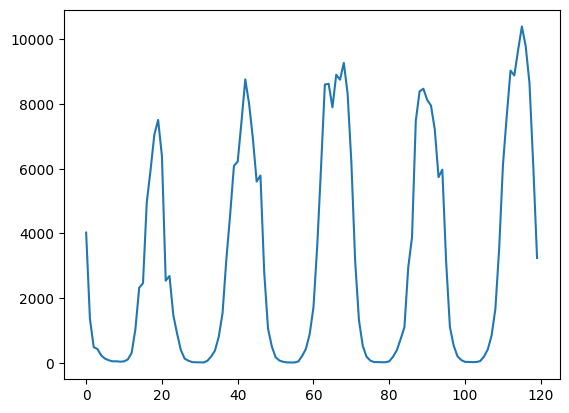

In [44]:
forecast = examplatory_forecast_model.predict(X_forecast)

forecast = [int(round(item, 0)) for item in forecast]


df_merge2["forecast"] = forecast

plt.plot(forecast)
